In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

# __Baseline model (1yr)__

## __1. DataFrame Preprocessing__

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


## __2. Data Splitting__

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=10)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

In [4]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=365)  # 1년

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((337, 1), (258, 1))

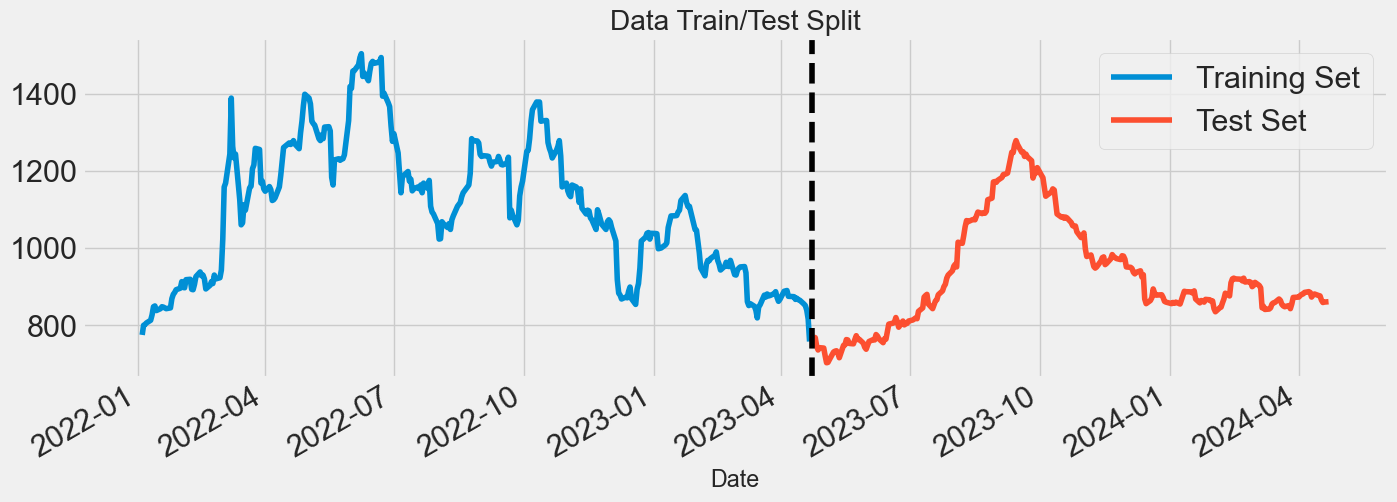

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

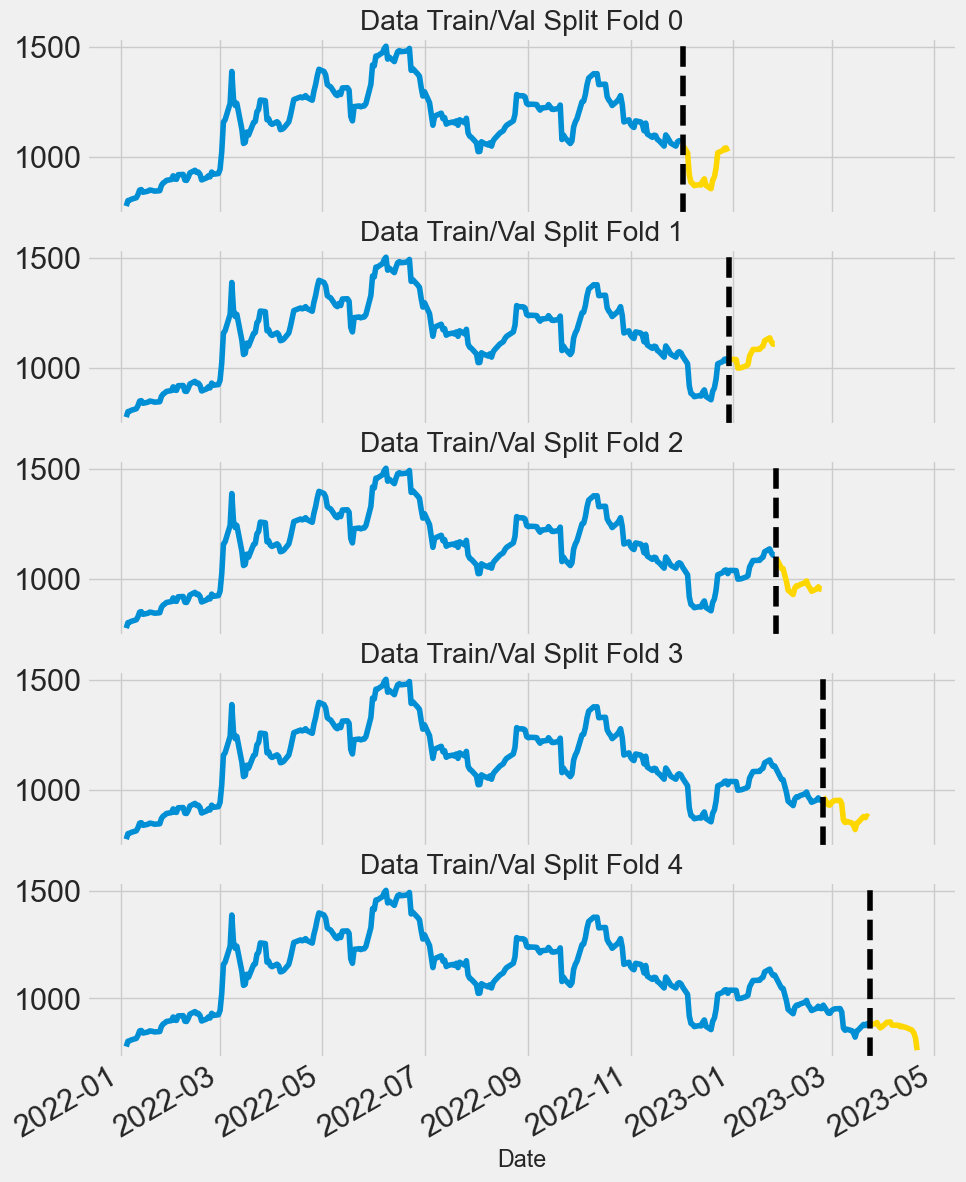

In [6]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=20)

fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

## __3. Feature Engineering__

### __3.1 Trend, Seasonal__

In [7]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

### __3.2. Simple Rolling Mean Average__

In [8]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [9]:
# 예측하고자 하는 기준이 짧으므로, 단기(5일(1주)) 및 장기 (10일(2주), 20일(1개월), 60일(3개월), 120일(6개월)) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120]) # train 데이터가 거의 1년으로 예상되므로 240일은 제외
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])

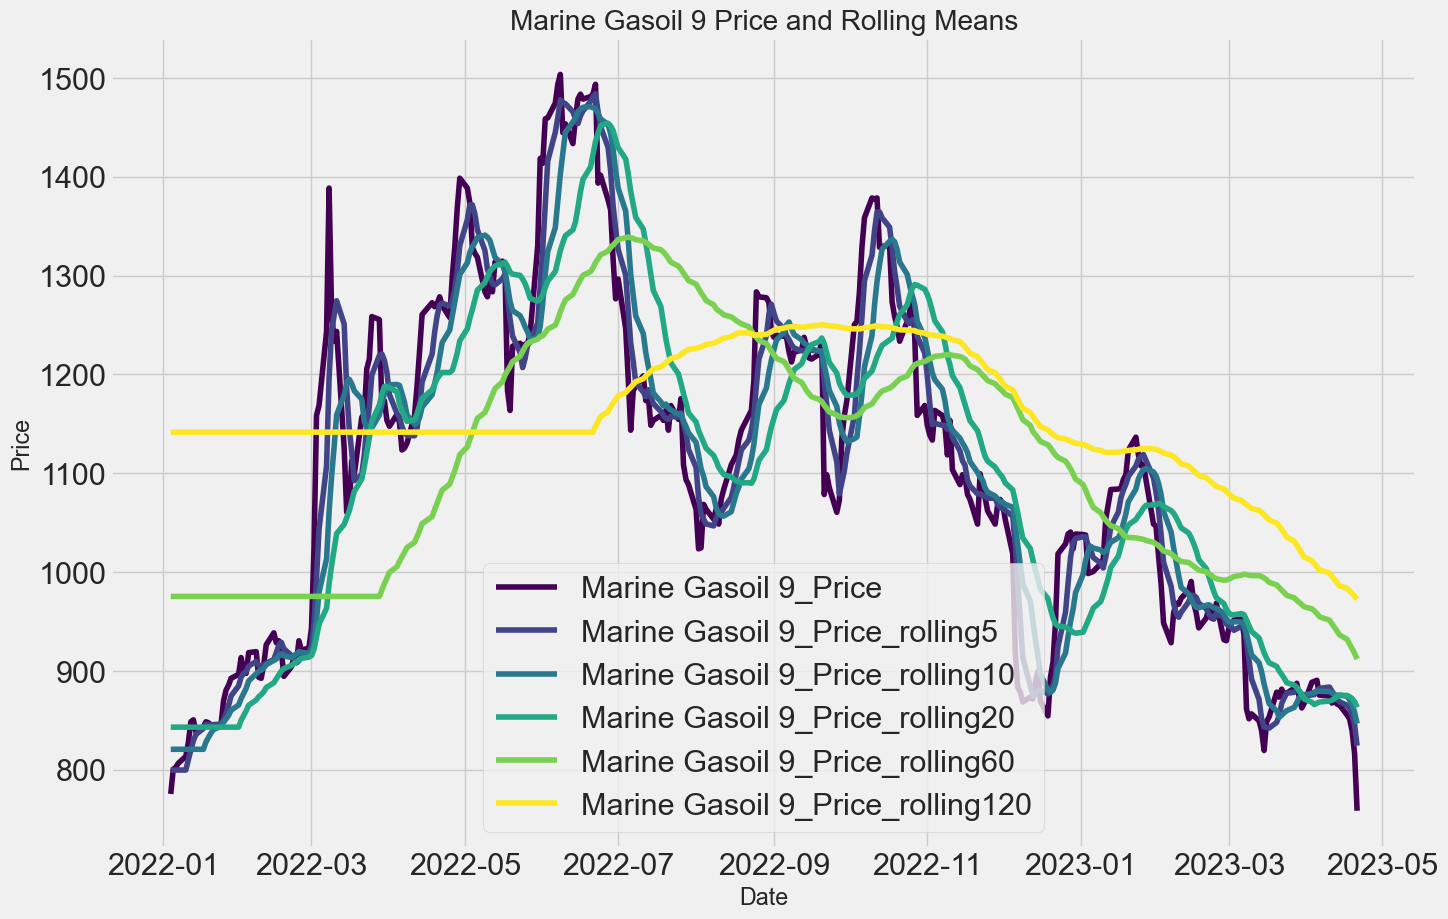

In [10]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### __3.3 Lag Feature__ 

In [11]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

In [12]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])

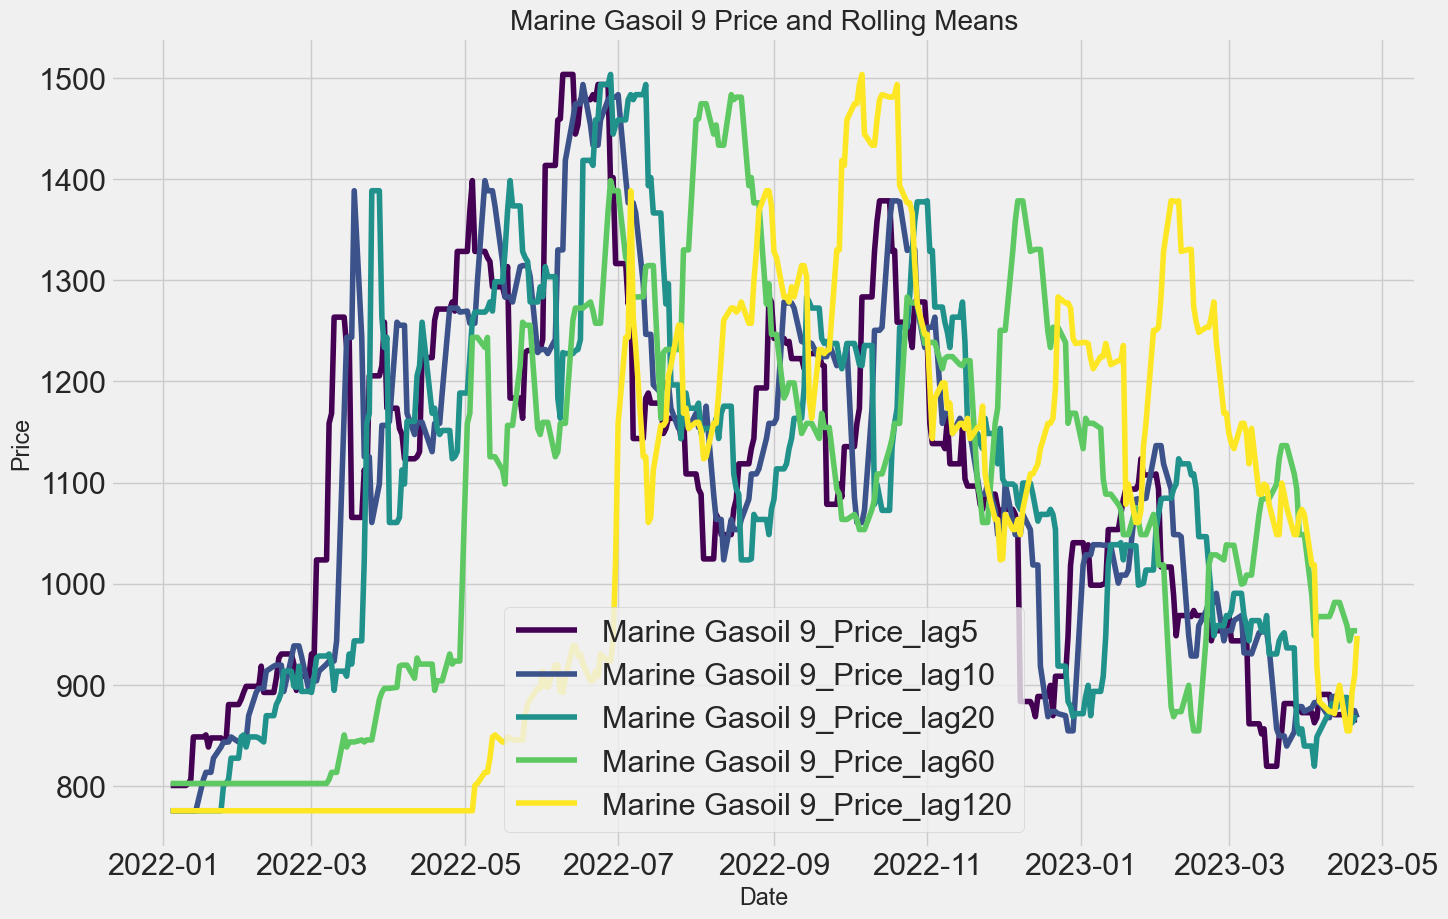

In [13]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### __3.4 Dummies__

In [14]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [15]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_lag5,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,824.35,-5.231626,799.7,820.7,843.10,975.375000,1141.545833,800.5,775.5,775.5,802.5,775.5,2022,1,1,1,4,1,4
2022-01-05,800.5,824.35,-3.915246,799.7,820.7,843.10,975.375000,1141.545833,800.5,775.5,775.5,802.5,775.5,2022,1,1,2,5,1,5
2022-01-06,802.5,824.35,-0.995419,799.7,820.7,843.10,975.375000,1141.545833,800.5,775.5,775.5,802.5,775.5,2022,1,1,3,6,1,6
2022-01-07,806.5,824.35,2.860041,799.7,820.7,843.10,975.375000,1141.545833,800.5,775.5,775.5,802.5,775.5,2022,1,1,4,7,1,7
2022-01-10,813.5,824.35,6.379868,799.7,820.7,843.10,975.375000,1141.545833,800.5,775.5,775.5,802.5,775.5,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,855.5,841.35,-0.995419,865.1,874.4,875.20,932.033333,983.558333,870.5,874.5,887.5,958.5,854.5,2023,2,4,0,17,16,107
2023-04-18,851.5,831.15,2.860041,861.9,870.7,873.85,927.283333,980.916667,866.5,874.5,872.5,943.5,854.5,2023,2,4,1,18,16,108
2023-04-19,839.5,820.00,6.379868,855.7,865.7,872.15,922.633333,978.341667,865.5,874.5,862.5,953.5,893.5,2023,2,4,2,19,16,109


## __4.Cross Validation__

In [16]:
validation_start_date = test_start_date - pd.Timedelta(days=31)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((317, 20), (20, 20), (258, 20))

In [17]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [18]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:linear', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1277.89702
[100]	validation_0-rmse:602.56228
[200]	validation_0-rmse:316.35315
[300]	validation_0-rmse:222.04710
[400]	validation_0-rmse:180.44445
[500]	validation_0-rmse:164.18409
[600]	validation_0-rmse:156.62096
[700]	validation_0-rmse:152.47570
[800]	validation_0-rmse:150.07095
[900]	validation_0-rmse:149.13202
[1000]	validation_0-rmse:148.46984
[1100]	validation_0-rmse:148.00108
[1200]	validation_0-rmse:147.62663
[1300]	validation_0-rmse:147.46243
[1362]	validation_0-rmse:147.49900
[0]	validation_0-rmse:1209.79610
[100]	validation_0-rmse:476.52871
[200]	validation_0-rmse:198.58795
[300]	validation_0-rmse:93.68940
[400]	validation_0-rmse:57.97264
[500]	validation_0-rmse:46.81902
[600]	validation_0-rmse:42.16162
[700]	validation_0-rmse:40.44079
[800]	validation_0-rmse:39.54936
[900]	validation_0-rmse:39.09683
[1000]	validation_0-rmse:38.91204
[1100]	validation_0-rmse:38.77964
[1200]	validation_0-rmse:38.68251
[1300]	validation_0-rmse:38.65776
[1400]	validation_

In [20]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [113.44711739676339, 33.36598532540457, 26.828401838030135, 43.18258013044085, 22.78434862409319]
Average MAE across folds: 47.92
RMSE for each fold: [147.45494779967777, 38.618710164772416, 33.95810724984413, 51.29529897513799, 29.869930673234364]
Average RMSE across folds: 60.24
MAPE for each fold: [8.368707705337604, 2.7527922877988704, 2.237583303307521, 4.339305192217326, 2.5165271755366567]
Average MAPE across folds: 4.04


## __5. XGBoost__

In [21]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:893.42421
[100]	validation_0-rmse:331.47524
[200]	validation_0-rmse:126.08695
[300]	validation_0-rmse:56.84303
[400]	validation_0-rmse:35.83475
[500]	validation_0-rmse:31.02545
[600]	validation_0-rmse:30.08139
[700]	validation_0-rmse:29.92404
[800]	validation_0-rmse:29.87531
[854]	validation_0-rmse:29.89831


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [22]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,874.313660
2024-04-17,865.5,NaN,877.422485
2024-04-18,859.5,NaN,877.515137


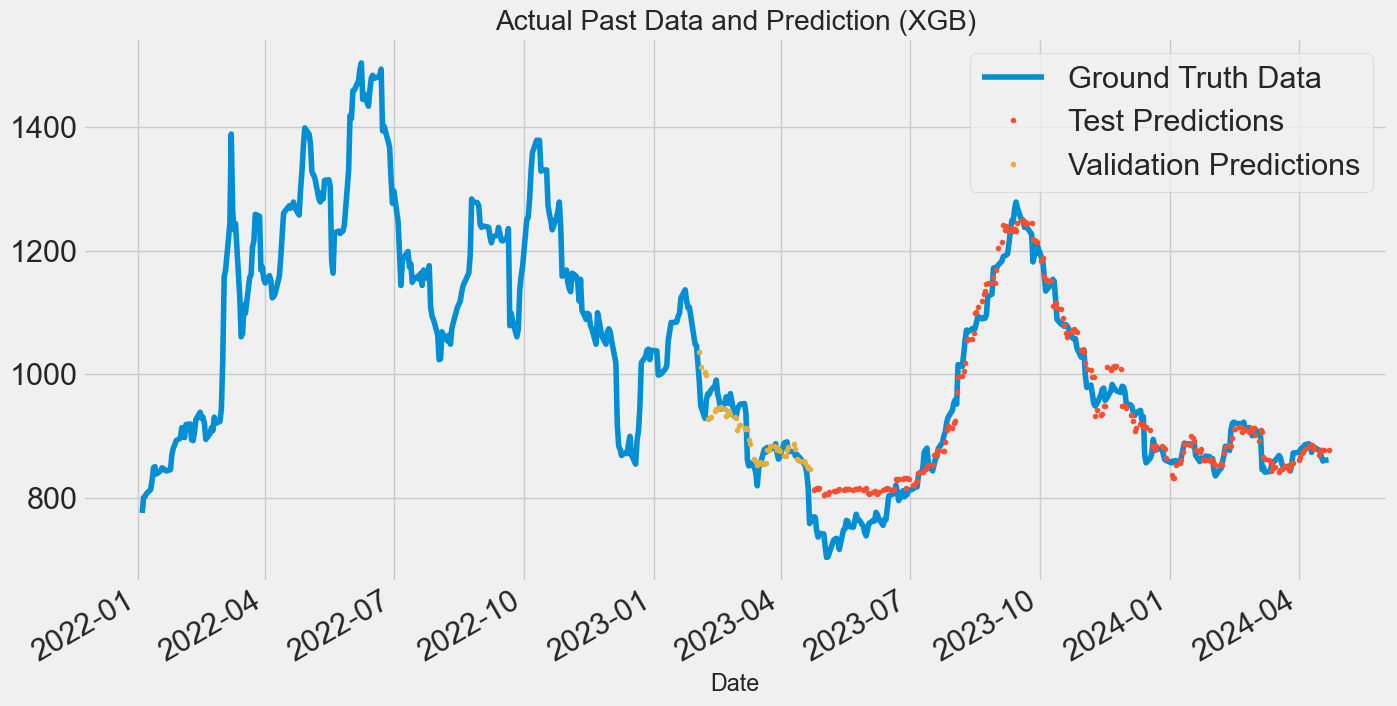

In [23]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

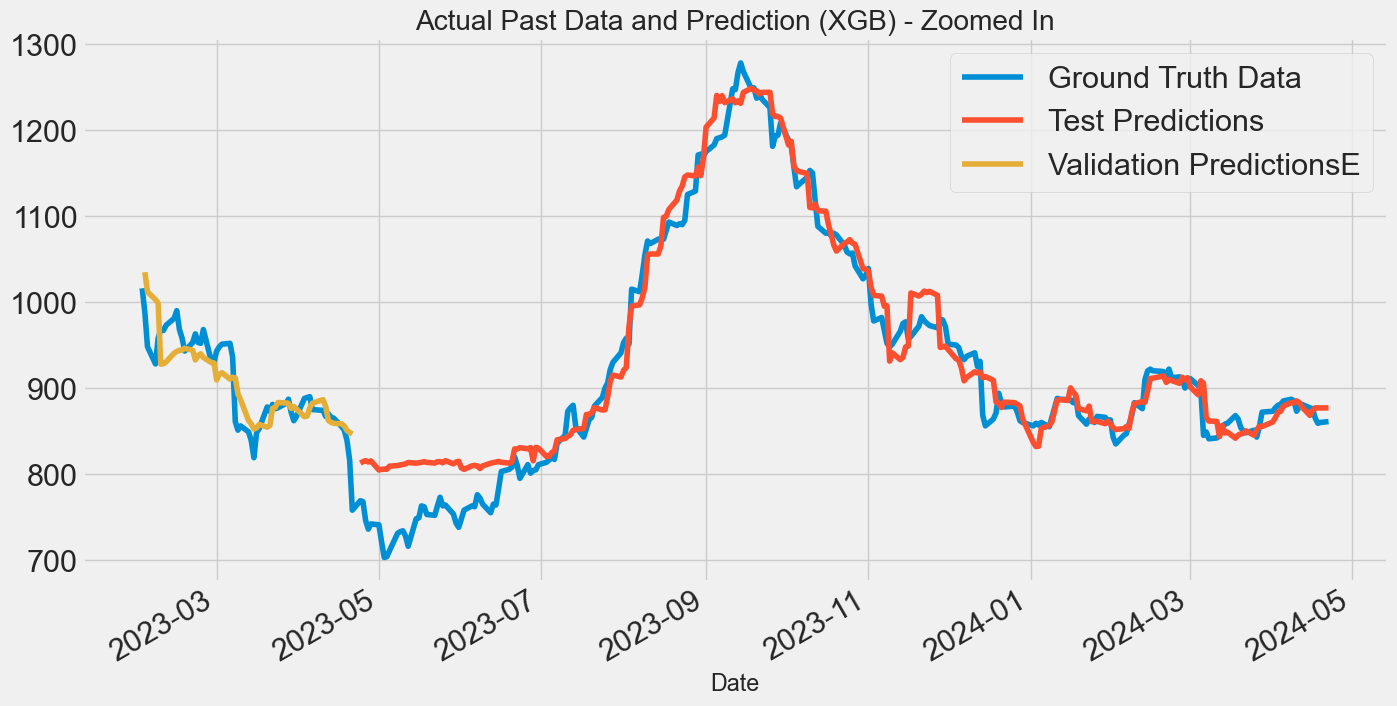

In [24]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation PredictionsE'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

# 1/3 splitting

In [25]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


In [26]:
# total_business_days는 실제 데이터의 인덱스입니다.
total_business_days = len(ts.index)

# 1/3 지점과 2/3 지점의 인덱스를 계산합니다.
one_third_point_index = int(total_business_days * 1/3)
two_third_point_index = int(total_business_days * 2/3)

# 1/3 지점과 2/3 지점의 날짜를 가져옵니다.
one_third_date = ts.index[one_third_point_index]
two_third_date = ts.index[two_third_point_index]

total_business_days, one_third_date, two_third_date

(595, Timestamp('2022-10-10 00:00:00'), Timestamp('2023-07-14 00:00:00'))

In [27]:
test_start_date = two_third_date

train_val = ts.loc[ts.index < test_start_date]
test = ts.loc[ts.index >= test_start_date]

train_val.shape, test.shape

((396, 1), (199, 1))

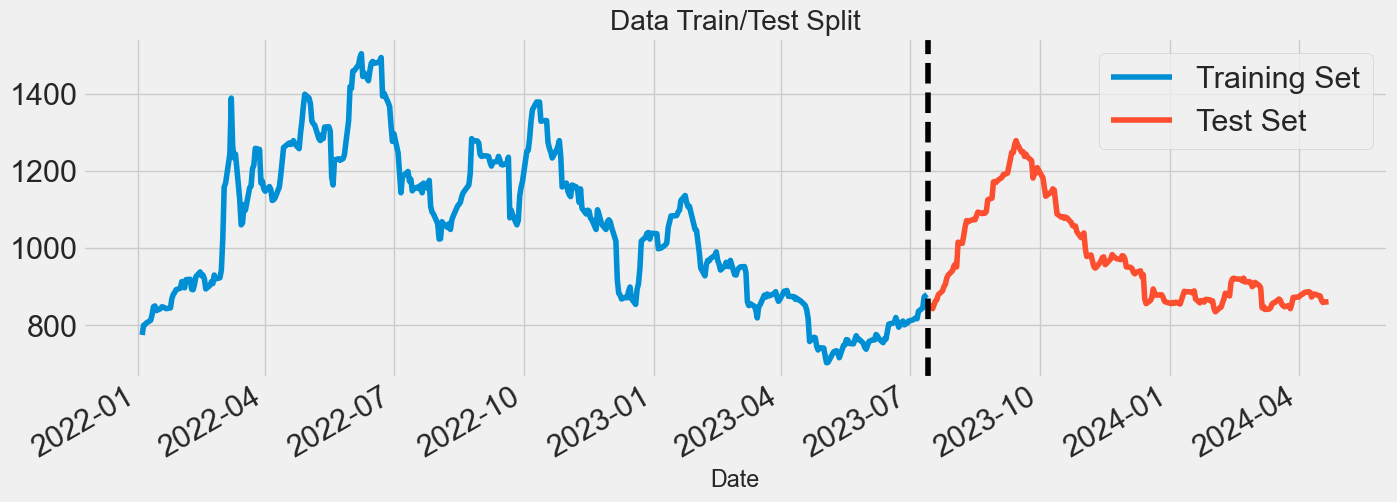

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

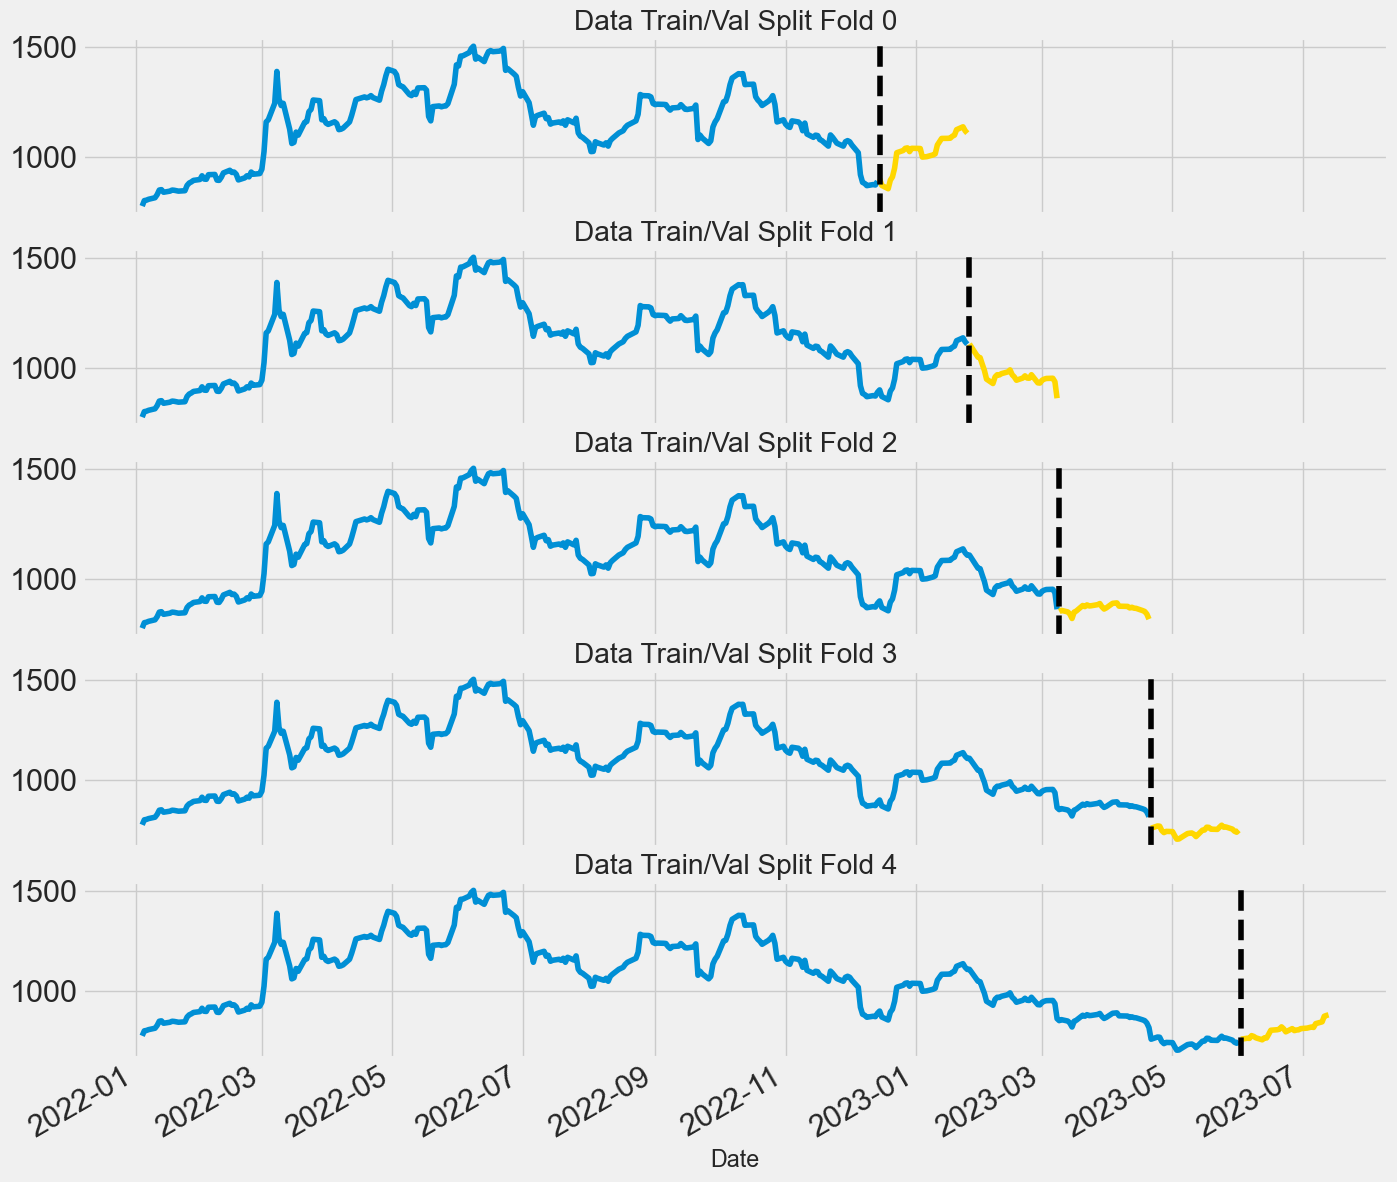

In [29]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=30)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [30]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

In [31]:
# 예측하고자 하는 기준이 짧으므로, 단기(5일(1주)) 및 장기 (10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년)) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])

In [32]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120])

In [33]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [34]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_lag5,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,824.350000,-5.231626,799.700000,820.7,843.100,975.375000,1141.545833,800.5,775.500000,775.5,802.5,775.5,2022,1,1,1,4,1,4
2022-01-05,800.5,824.350000,-3.915246,799.700000,820.7,843.100,975.375000,1141.545833,800.5,775.500000,775.5,802.5,775.5,2022,1,1,2,5,1,5
2022-01-06,802.5,824.350000,-0.995419,799.700000,820.7,843.100,975.375000,1141.545833,800.5,775.500000,775.5,802.5,775.5,2022,1,1,3,6,1,6
2022-01-07,806.5,824.350000,2.860041,799.700000,820.7,843.100,975.375000,1141.545833,800.5,775.500000,775.5,802.5,775.5,2022,1,1,4,7,1,7
2022-01-10,813.5,824.350000,6.379868,799.700000,820.7,843.100,975.375000,1141.545833,800.5,775.500000,775.5,802.5,775.5,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,836.5,841.500000,-3.915246,820.900000,813.9,802.625,772.383333,854.441667,819.5,801.500000,808.5,731.5,851.5,2023,3,7,4,7,27,188
2023-07-10,845.5,845.166667,-0.995419,827.166667,817.3,807.125,772.216667,852.125000,819.5,811.500000,808.5,728.5,849.5,2023,3,7,0,10,28,191
2023-07-11,873.5,848.466667,2.860041,838.500000,824.5,812.525,772.583333,849.933333,817.5,814.166667,820.5,716.5,849.5,2023,3,7,1,11,28,192


In [41]:
validation_start_date = test_start_date - pd.Timedelta(days=29)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((376, 20), (20, 20), (199, 20))

In [42]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [43]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:linear', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1313.83704
[100]	validation_0-rmse:608.51180
[200]	validation_0-rmse:337.60742
[300]	validation_0-rmse:242.10165
[400]	validation_0-rmse:210.87998
[500]	validation_0-rmse:197.94832
[600]	validation_0-rmse:193.55985
[700]	validation_0-rmse:191.53998
[800]	validation_0-rmse:190.75840
[900]	validation_0-rmse:190.46874
[1000]	validation_0-rmse:190.30177
[1063]	validation_0-rmse:190.41969
[0]	validation_0-rmse:1157.33270
[100]	validation_0-rmse:424.66649
[200]	validation_0-rmse:171.93436
[300]	validation_0-rmse:85.86076
[400]	validation_0-rmse:58.34778
[500]	validation_0-rmse:49.74013
[600]	validation_0-rmse:46.73296
[700]	validation_0-rmse:45.69114
[800]	validation_0-rmse:45.16274
[900]	validation_0-rmse:44.91447
[1000]	validation_0-rmse:44.76120
[1100]	validation_0-rmse:44.72027
[1200]	validation_0-rmse:44.68525
[1237]	validation_0-rmse:44.68800
[0]	validation_0-rmse:1084.66822
[100]	validation_0-rmse:404.39826
[200]	validation_0-rmse:156.64122
[300]	validation_0-rms

In [45]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [159.90648489287406, 37.38004187381629, 41.68475064364347, 22.31758163914536, 30.796891645951703]
Average MAE across folds: 58.42
RMSE for each fold: [190.28587802750468, 44.679305238753095, 49.875402071216485, 27.237228950672513, 35.941013834419714]
Average RMSE across folds: 69.60
MAPE for each fold: [11.569332925360175, 3.1882248451344504, 4.011487172859359, 2.3435840750780024, 3.947032762865968]
Average MAPE across folds: 5.01


In [46]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:772.51961
[100]	validation_0-rmse:224.75163
[200]	validation_0-rmse:59.85334
[300]	validation_0-rmse:36.72612
[329]	validation_0-rmse:39.45445


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [47]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,824.481445
2024-04-17,865.5,NaN,824.481445
2024-04-18,859.5,NaN,824.481445


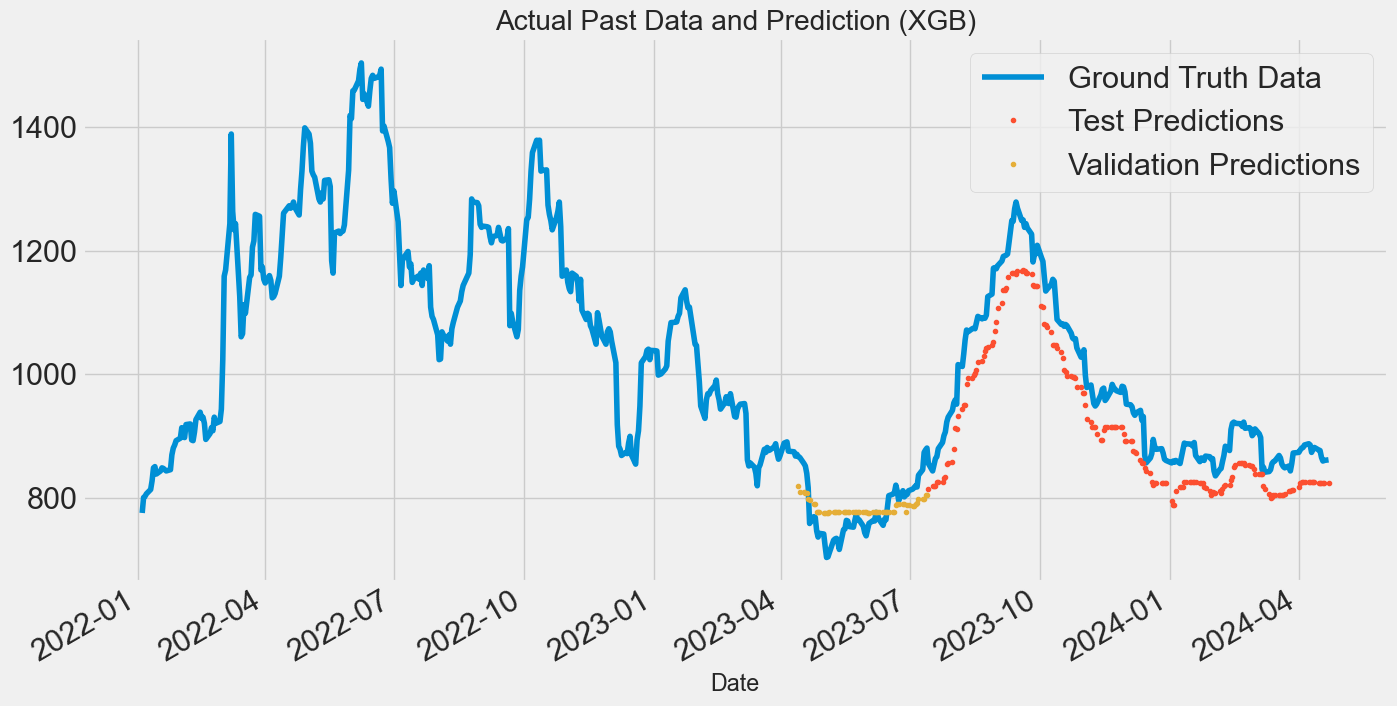

In [48]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

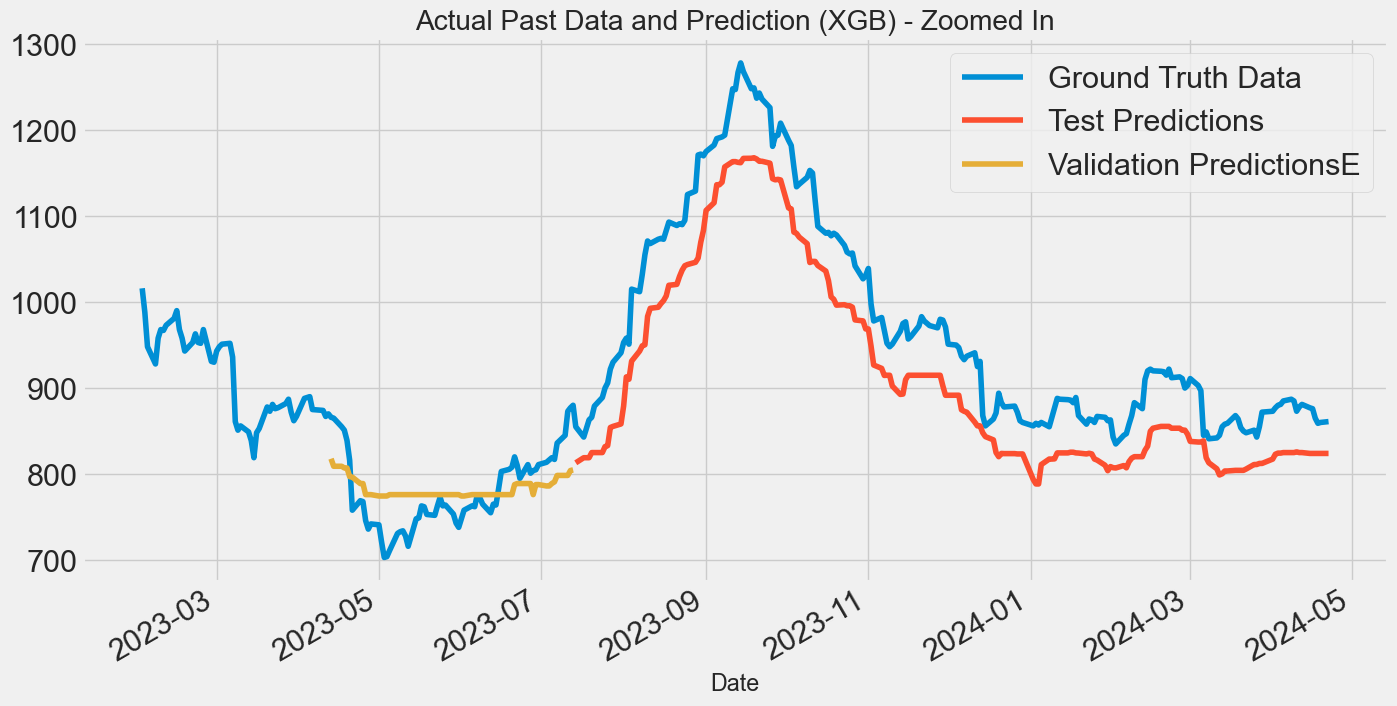

In [49]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation PredictionsE'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()